# Preparing data for clustering

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import math
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn import preprocessing
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import random 
random.seed(33)

In [4]:
listings = pd.read_csv('./Data/listings_clean.csv', index_col=0)

In [5]:
numerical_features = ['latitude', 'longitude', 'accommodates', 'bathrooms','bedrooms', 'beds']

In [6]:
reviewScoresColums = listings.filter(regex='review_scores.*').columns
numerical_features.extend(reviewScoresColums)

In [7]:
boolean_features = ['instant_bookable', 'is_business_travel_ready']

In [8]:
AmenColums = listings.filter(regex='Amen_.*').columns
boolean_features.extend(AmenColums)

In [9]:
categorical_features = ['neighbourhood_cleansed', 'property_type', 'bed_type']
listings_categorical = pd.get_dummies(listings[categorical_features], columns=categorical_features, 
                            prefix=["Neigh", "Property", "Bed"])

In [10]:
listingsCluster = pd.concat([listings[numerical_features],listings[categorical_features],listings[boolean_features]], axis=1)

In [11]:
listingsCluster[boolean_features]=listingsCluster[boolean_features]

In [12]:
to_categorical = categorical_features + boolean_features
indCatColumns = [listingsCluster.columns.get_loc(col) for col in to_categorical]

In [13]:
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()

In [14]:
listingsCluster[numerical_features] = RS.fit_transform(listingsCluster[numerical_features])
listingsCluster.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,Amen_Waterfront,Amen_Well-lit path to entrance,Amen_Wheelchair accessible,Amen_Wide clearance to bed,Amen_Wide clearance to shower,Amen_Wide doorway,Amen_Wide entryway,Amen_Wide hallway clearance,Amen_Window guards,Amen_Wireless Internet
id,,,,,,,,,,,,,,,,,,,,,
18628,0.466350,0.293560,-1.0,0.0,-1.0,-0.5,-0.625,-1.0,-1.0,-1.0,...,0,1,0,0,0,0,0,0,0,1
19864,-0.297475,-0.445500,-1.0,0.0,-1.0,-0.5,-0.375,-1.0,-1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
21512,0.480205,-1.041027,-1.0,0.0,-1.0,-0.5,-1.875,-1.0,-2.0,-1.0,...,0,0,1,0,0,0,0,0,0,1
23021,0.378545,-0.951813,3.0,2.0,3.0,1.5,-1.750,-2.0,-2.0,-1.0,...,0,0,1,0,0,0,0,0,0,1
24805,0.284240,-0.185544,-0.5,0.0,-1.0,0.0,0.750,-2.0,-2.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
! pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /home/dsc/anaconda3/lib/python3.5/site-packages
    100% |████████████████████████████████| 12.1MB 27kB/s  eta 0:00:01   62% |████████████████████            | 7.6MB 9.3MB/s eta 0:00:01
Requirement already up-to-date: scikit-learn<0.20.0,>=0.19.0 in /home/dsc/anaconda3/lib/python3.5/site-packages (from kmodes)
    100% |████████████████████████████████| 49.7MB 5.7kB/s eta 0:00:01  5% |█▊                              | 2.6MB 9.2MB/s eta 0:00:06    35% |███████████▍                    | 17.6MB 19.6MB/s eta 0:00:02    49% |███████████████▉                | 24.6MB 11.2MB/s eta 0:00:03    60% |███████████████████▌            | 30.2MB 18.1MB/s eta 0:00:02    72% |███████████████████████         | 35.8MB 12.0MB/s eta 0:00:02
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0
  Found existing installation: scipy 1.0.0
    Uninstalling scipy-1.0.0:
      Successfully uninstalled scipy-1

In [19]:
! pip install --upgrade pip

    100% |████████████████████████████████| 1.3MB 217kB/s ta 0:00:011
  Found existing installation: pip 9.0.2
    Uninstalling pip-9.0.2:
      Successfully uninstalled pip-9.0.2


In [15]:
from kmodes.kprototypes import KPrototypes

In [16]:
for cat_col in categorical_features:
    listingsCluster[cat_col] = preprocessing.LabelEncoder().fit_transform(listingsCluster[cat_col])
    
X = listingsCluster.values

In [17]:
def distance_dissim(X,Y,gamma,categorical):
    no_categorical = [i for i in range(len(X)) if i not in categorical]
    Xnum = np.asanyarray([X[ii] for ii in no_categorical]).astype(np.float64)
    Ynum = np.asanyarray([Y[ii] for ii in no_categorical]).astype(np.float64)
    Xcat = np.asanyarray([X[ii] for ii in categorical])
    Ycat = np.asanyarray([Y[ii] for ii in categorical])
    
    distance_dissim = distance.euclidean(Xnum, Ynum) + gamma * np.sum(Xcat != Ycat)
    
    return distance_dissim

In [95]:
meandist=[]
clusters = range(1,10)

for k in clusters:
    model = KPrototypes(n_clusters=k, init='Huang', n_init=1, verbose=2)
    model_fit = model.fit(X, categorical = indCatColumns)
    clusassign= model_fit.predict(X, categorical = indCatColumns)
    centroids = list()
    for i in range(k):
        centroids.append(list())
        centroids[i] = np.append(model_fit.cluster_centroids_[0][i], model_fit.cluster_centroids_[1][i])
    meandist.append(sum(np.min(cdist(X,centroids, metric=lambda X,Y: distance_dissim(X,Y,gamma = gamma,categorical = indCatColumns)),axis=1))/listingsCluster.shape[0])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 156291.0399360084
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1221, ncost: 139925.29568103992
Run: 1, iteration: 2/100, moves: 499, ncost: 139485.66612405892
Run: 1, iteration: 3/100, moves: 277, ncost: 139329.47548990216
Run: 1, iteration: 4/100, moves: 149, ncost: 139222.676274198
Run: 1, iteration: 5/100, moves: 106, ncost: 139185.54226310723
Run: 1, iteration: 6/100, moves: 53, ncost: 139167.62525825828
Run: 1, iteration: 7/100, moves: 45, ncost: 139153.93820449398
Run: 1, iteration: 8/100, moves: 31, ncost: 139148.27410588006
Run: 1, iteration: 9/100, moves: 18, ncost: 139145.21135670328
Run: 1, iteration: 10/100, moves: 24, ncost: 139139.8941654597
Run: 1, iteration: 11/100, moves: 26, ncost: 139131.55928837543
Run: 1, iteration: 12/100, moves: 37, ncost: 139118.80045867912
Run: 1, iteration

Run: 1, iteration: 2/100, moves: 1683, ncost: 100596.87453925617
Run: 1, iteration: 3/100, moves: 505, ncost: 100010.03823966916
Run: 1, iteration: 4/100, moves: 240, ncost: 99763.51646286533
Run: 1, iteration: 5/100, moves: 187, ncost: 99705.10667500862
Run: 1, iteration: 6/100, moves: 70, ncost: 99677.21367098746
Run: 1, iteration: 7/100, moves: 87, ncost: 99649.21976370878
Run: 1, iteration: 8/100, moves: 96, ncost: 99622.14516086581
Run: 1, iteration: 9/100, moves: 115, ncost: 99586.66108507392
Run: 1, iteration: 10/100, moves: 84, ncost: 99561.16939415444
Run: 1, iteration: 11/100, moves: 93, ncost: 99530.67343614106
Run: 1, iteration: 12/100, moves: 58, ncost: 99508.49509327557
Run: 1, iteration: 13/100, moves: 90, ncost: 99442.05452337663
Run: 1, iteration: 14/100, moves: 267, ncost: 98282.71077219375
Run: 1, iteration: 15/100, moves: 803, ncost: 95749.73765980656
Run: 1, iteration: 16/100, moves: 534, ncost: 95403.25194719208
Run: 1, iteration: 17/100, moves: 171, ncost: 95372.

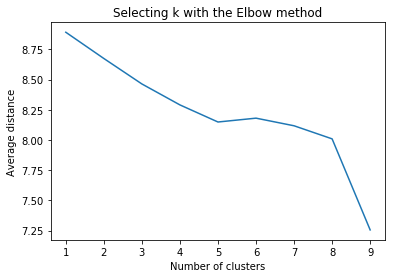

In [96]:
plt.plot(clusters,meandist)
plt.xlabel("Number of clusters")
plt.ylabel("Average distance")
plt.title("Selecting k with the Elbow method")
plt.show()

In [ ]:
#According to the Elbow method, we could consider 5 clusters and maybe 9 clusters

In [102]:
listings['Cluster9'] = model_fit.labels_

In [18]:
model5 = KPrototypes(n_clusters=5, init='Huang', n_init=1, verbose=2)
model_fit5 = model5.fit(X, categorical = indCatColumns)
clusassign5= model_fit5.predict(X, categorical = indCatColumns)
listings['Cluster5'] = model_fit5.labels_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2017, ncost: 111693.33415873126
Run: 1, iteration: 2/100, moves: 1480, ncost: 109485.1562259818
Run: 1, iteration: 3/100, moves: 720, ncost: 108971.92134480539
Run: 1, iteration: 4/100, moves: 429, ncost: 108784.7774215418
Run: 1, iteration: 5/100, moves: 228, ncost: 108730.45510934215
Run: 1, iteration: 6/100, moves: 113, ncost: 108719.73918550617
Run: 1, iteration: 7/100, moves: 64, ncost: 108716.00918472542
Run: 1, iteration: 8/100, moves: 20, ncost: 108714.1876668095
Run: 1, iteration: 9/100, moves: 9, ncost: 108712.06272762883
Run: 1, iteration: 10/100, moves: 3, ncost: 108711.8888854139
Run: 1, iteration: 11/100, moves: 3, ncost: 108711.86580891862
Run: 1, iteration: 12/100, moves: 1, ncost: 108711.86272164901
Run: 1, iteration: 13/100, moves: 0, ncost: 108711.86272164901


In [19]:
model9 = KPrototypes(n_clusters=9, init='Huang', n_init=1, verbose=2)
model_fit9 = model9.fit(X, categorical = indCatColumns)
clusassign9= model_fit9.predict(X, categorical = indCatColumns)
listings['Cluster9'] = model_fit9.labels_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3977, ncost: 103566.71535170995
Run: 1, iteration: 2/100, moves: 1457, ncost: 100918.93382495378
Run: 1, iteration: 3/100, moves: 817, ncost: 100028.0165577798
Run: 1, iteration: 4/100, moves: 709, ncost: 99266.46747208296
Run: 1, iteration: 5/100, moves: 755, ncost: 98445.2080154068
Run: 1, iteration: 6/100, moves: 568, ncost: 98201.38860420325
Run: 1, iteration: 7/100, moves: 463, ncost: 98043.60409650899
Run: 1, iteration: 8/100, moves: 539, ncost: 97817.5500741896
Run: 1, iteration: 9/100, moves: 495, ncost: 97643.8057829585
Run: 1, iteration: 10/100, moves: 433, ncost: 97453.67325187751
Run: 1, iteration: 11/100, moves: 308, ncost: 97381.32041617998
Run: 1, iteration: 12/100, moves: 234, ncost: 97313.10168570028
Run: 1, iteration: 13/100, moves: 173, ncost: 97248.01920294411
Run: 1, iteration: 14/100, moves: 167, ncost: 97211.93651496574
Run: 1, iteration: 15/100, moves

In [20]:
listings.to_csv('./Data/listingsCluster.csv', index=True)

In [21]:
#Testing clustering with Silhoutte

In [22]:
labels = model_fit9.labels_
gamma = model_fit9.gamma
Silhoutte9 = silhouette_score(X, labels, metric= lambda X,Y: distance_dissim(X,Y,gamma = gamma,categorical = indCatColumns))
print(Silhoutte9)

0.03627972766611436


In [23]:
labels = model_fit5.labels_
gamma = model_fit5.gamma
Silhoutte5 = silhouette_score(X, labels, metric= lambda X,Y: distance_dissim(X,Y,gamma = gamma,categorical = indCatColumns))
print(Silhoutte5)

0.05639430798505945
